**Credit Card Fraud Detection**

This kernel is using QDA (Quadratic Discriminant Analysis), LR (Logistic Regression), and SVM (Support Vector Machine) models to help detect Fraud Credit Card transactions.

With the provided dataset, we have 492 frauds out of 284,807 transactions, or the positive class (frauds) account for 0.172% of all transactions. In addition, we have a high dimentional dataset with 30 features, including 28 PCA-ed features (V1, V2, ... V28), 'Amount', and 'Time' features.

Due to the highly unbalanced dataset, we will apply Sampling technique to under-sample the majority class, and over-sample the minority class before training process.

Also, we used recursive feature elimination and cross-validated technique for features selection.

In this exercise, we will focus on the Recall score of the model - Fraud detection (True Negative Classification); however, we also consider the trade-off on the Precision score - Normal transaction classification rate (True Positive Classification).


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn import discriminant_analysis

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN

from sklearn.metrics import confusion_matrix
import itertools
from itertools import cycle

from sklearn import discriminant_analysis

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

creditcard.csv



In [5]:
df = pd.read_csv("../input/creditcard.csv")
#df = pd.read_csv("./data/creditcard.csv")

**1/ Exploring the Dataset**

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
np.array(df.isnull().sum())

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

The dataset does not have any missing data.

In [9]:
dfFraud = df[df.Class==1]
dfNorm = df[df.Class==0]
ratio = float(len(dfFraud))/len(dfNorm)
print(ratio)

0.0017304750013189597


Apparently, the dataset is highly unbalanced, the positive class (Fraud transactions) account for 0.172% of all transactions.

**2/ Selecting features**

In [10]:
y_target = df.Class
X_data = df.drop(['Class'], axis=1)

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

Optimal number of features : 11


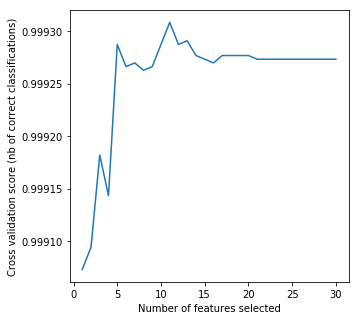

In [11]:
# Create the RFE object and compute a cross-validated score.
lda = discriminant_analysis.LinearDiscriminantAnalysis()#SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=lda, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(X_data, y_target)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [12]:
rfecv.grid_scores_

array([ 0.99907306,  0.99909412,  0.9991819 ,  0.99914328,  0.99928724,
        0.99926617,  0.99926968,  0.99926266,  0.99926617,  0.99928724,
        0.9993083 ,  0.99928724,  0.99929075,  0.9992767 ,  0.99927319,
        0.99926968,  0.9992767 ,  0.9992767 ,  0.9992767 ,  0.9992767 ,
        0.99927319,  0.99927319,  0.99927319,  0.99927319,  0.99927319,
        0.99927319,  0.99927319,  0.99927319,  0.99927319,  0.99927319])

In [13]:
rfecv.support_

array([False, False, False,  True,  True, False, False,  True, False,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [14]:
rfecv.ranking_

array([20,  5,  3,  1,  1,  2,  8,  1, 11,  1,  1,  1,  1, 16,  1, 15,  1,
        1,  1,  7, 10,  4, 18, 17, 12, 14, 13,  6,  9, 19])

List of selected features:

In [15]:
X_data.columns.values[rfecv.support_]

array(['V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17',
       'V18'], dtype=object)

**3/ Preparing Training and Testing datasets**

* Split the data into Normal and Fraud datasets
* Shuffle the data before taking sample to make sure the data from each class is randomly selected
* Eliminate the features/predictors that have low/none support to the classification 

In [16]:
#Shuffle the dataframes so that the training is done in a random order.
dfNorm = shuffle(dfNorm)
dfFraud = shuffle(dfFraud)

# Set X_train equal to 80% of the fraudulent transactions.
X_train = dfFraud.sample(frac=0.8)

# Add 80% of the normal transactions to X_train.
X_train = pd.concat([X_train, dfNorm.sample(frac = 0.8)], axis = 0)

# X_test contains all the transaction not in X_train.
X_test = df.loc[~df.index.isin(X_train.index)]

y_train = X_train['Class']
y_test = X_test['Class']

X_train = X_train.iloc[:,rfecv.support_]
X_test = X_test.iloc[:,rfecv.support_]

In [17]:
X_data.shape, X_train.shape, X_test.shape

((284807, 30), (227846, 11), (56961, 11))

In [18]:
X_train.columns.values

array(['V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17',
       'V18'], dtype=object)

The Training dataset is now containing only features supporting the classification process.

**4/ Resampling data**

4.1/ Transforming Training Dataset
The ratio 0.17% between the Fraud and Normal classes is showing an strongly unbalanced data in favor to the Normal class. Resampling is used to transform the Training dataset, in which we will under-resampling the Normal class, and make the Dataset balanced out between the Classes, this prevents fitting model from overfitting on the majority class.

Centroid Clustering technique is used to transform the Training dataset. Perform under-sampling by generating centroids based on clustering methods. Method that under samples the majority class by replacing a cluster of majority samples by the cluster centroid of a KMeans algorithm. This algorithm keeps N majority samples by fitting the KMeans algorithm with N cluster to the majority class and using the coordinates of the N cluster centroids as the new majority samples.

In [19]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_sample(X_train, y_train)

In [20]:
X_train_ = X_resampled
y_train_ = y_resampled
X_test_ = X_test
y_test_ = y_test

* Verifying the number of features from the original Training Dataset and the transfomred Training Dataset.

In [21]:
X_train.shape, X_train_.shape, y_train.shape, y_train_.shape

((227846, 11), (788, 11), (227846,), (788,))

* Verifying the balancing between the Normal and Fraud classes.

In [22]:
sum(y_train_==1), sum(y_train_==0)

(394, 394)

4.2/ Examing the original Training dataset and its under-resamplingversion after the transforming process.

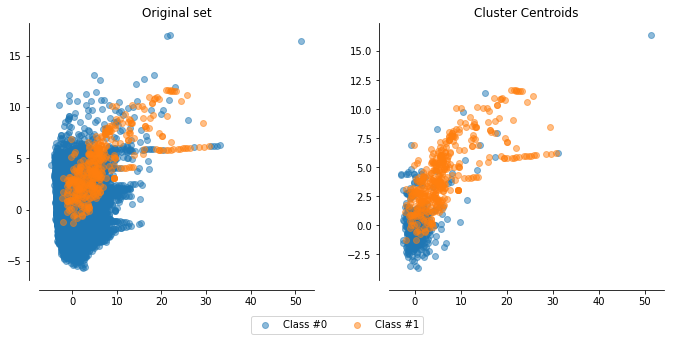

In [23]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X_train)

# Apply SMOTE + ENN
#sm = SMOTEENN(ratio = 'minority')
#X_resampled, y_resampled = sm.fit_sample(X_train, y_train)
X_res_vis = pca.transform(X_resampled)

# Two subplots, unpack the axes array immediately
plt.rcParams['figure.figsize'] = 10, 5
f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y_train == 0, 0], X_vis[y_train == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y_train == 1, 0], X_vis[y_train == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == 0, 0], X_res_vis[y_resampled == 0, 1],
            label="Class #0", alpha=0.5)
ax2.scatter(X_res_vis[y_resampled == 1, 0], X_res_vis[y_resampled == 1, 1],
            label="Class #1", alpha=0.5)
#ax2.set_title('SMOTE + ENN')
ax2.set_title('Cluster Centroids')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    #ax.set_xlim([-6, 8])
    #ax.set_ylim([-6, 6])

f.legend((c0, c1), ('Class #0', 'Class #1'), loc='lower center',
         ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

**5/ Fitting Models**

**5.1/ QDA model**

**5.1.1/ Fitting QDA model****

In [24]:
QDA_model = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA_model.fit(X_train_, y_train_)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

* ***QDA model Score on the Training Dataset:***

In [25]:
QDA_model.score(X_train_, y_train_)

0.89847715736040612

In [26]:
class_names = ["Normal", "Fraud"]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[368  26]
 [ 54 340]]
Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.14  0.86]]


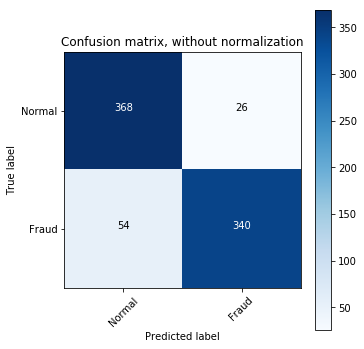

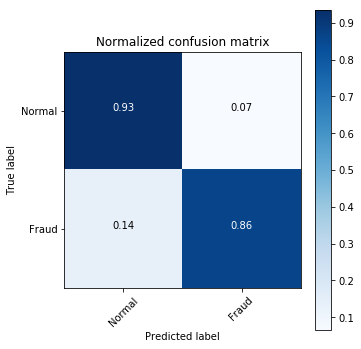

In [27]:
def plotConfusion(model, X, y):
    y_true, y_pred = y, model.predict(X)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

plotConfusion(QDA_model, X_train_, y_train_)

* ***QDA model Score on the Test Dataset:***

In [28]:
QDA_model.score(X_test_, y_test_)

0.97245483752040873

Confusion matrix, without normalization
[[55299  1564]
 [    5    93]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.05  0.95]]


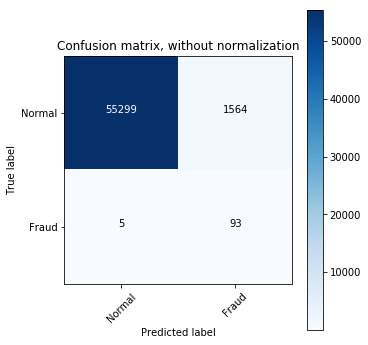

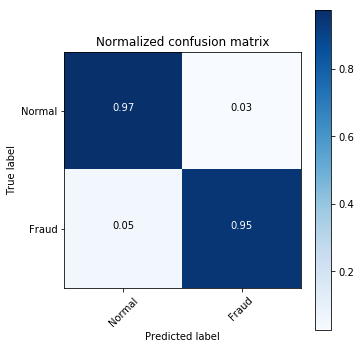

In [29]:
plotConfusion(QDA_model, X_test_, y_test_)

***5.1.2/ A glance at how the QDA Classification works on the Test Dataset:***

In [30]:
def plotModel(model, x, y, label):
    '''
    model: a fitted model
    x, y: two variables, should arrays
    label: true label
    '''
    x_min = x.min() - 1
    x_max = x.max() + 1
    y_min = y.min() - 1
    y_max = y.max() + 1
    import  matplotlib.pyplot as pl
    from matplotlib import colors
    colDict = {'red': [(0, 1, 1), (1, 0.7, 0.7)],
               'green': [(0, 1, 0.5), (1, 0.7, 0.7)],
               'blue': [(0, 1, 0.5), (1, 1, 1)]}
    cmap = colors.LinearSegmentedColormap('red_blue_classes', colDict)
    plt.cm.register_cmap(cmap=cmap)
    nx, ny = 200, 200
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ## plot colormap
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes')
    ## plot boundaries
    plt.contour(xx, yy, Z, [0.5], linewidths=1., colors='k')
    plt.contour(xx, yy, Z, [1], linewidths=1., colors='k')
    ## plot scatters ans true labels
    plt.scatter(x, y, c = label)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

labels = X_train.columns.values

def pairPlot(model, i, j):
    model.fit(X_test_.iloc[:,[i,j]], y_test_)
    plotModel(model, X_test_.iloc[:, i], X_test_.iloc[:, j], y_test_)
    plt.xlabel(labels[i])
    plt.ylabel(labels[j])


/opt/conda/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


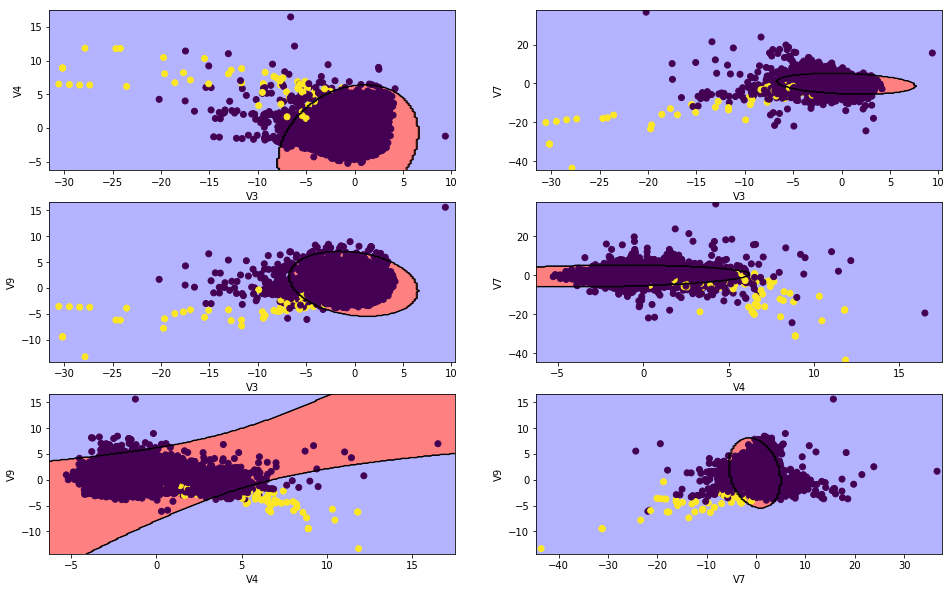

In [31]:
#QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()
plt.rcParams['figure.figsize'] = 16, 10
plt.subplot(321)
pairPlot(QDA_model, 0, 1)

plt.subplot(322)
pairPlot(QDA_model, 0, 2)

plt.subplot(323)
pairPlot(QDA_model, 0, 3)

plt.subplot(324)
pairPlot(QDA_model, 1, 2)

plt.subplot(325)
pairPlot(QDA_model, 1, 3)

plt.subplot(326)
pairPlot(QDA_model, 2, 3)

**5.2/ Logistic Regression model**

**4.2.1/ Fitting Logistic Regression model**

In [32]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
#GridSearchCV(cv=None,
 #            estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
 #              dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
 #            param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [33]:
#clf.fit(X_resampled2, y_resampled2)
clf.fit(X_train_, y_train_)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
clf.best_params_

{'C': 0.01}

**5.2.2/ Examining the Logistic Regression model**

*  ***Classification on the Training Dataset: ***

Confusion matrix, without normalization
[[373  21]
 [ 50 344]]
Normalized confusion matrix
[[ 0.95  0.05]
 [ 0.13  0.87]]


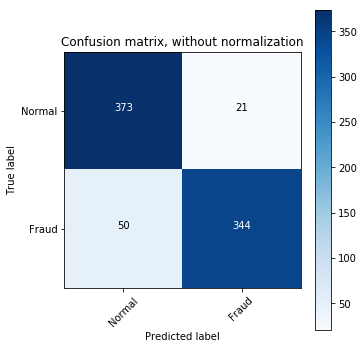

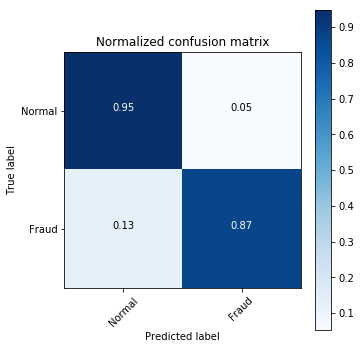

In [35]:
plotConfusion(clf, X_train_, y_train_)

* ***Classification on the Test Dataset: ***

Confusion matrix, without normalization
[[55277  1586]
 [    3    95]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.03  0.97]]


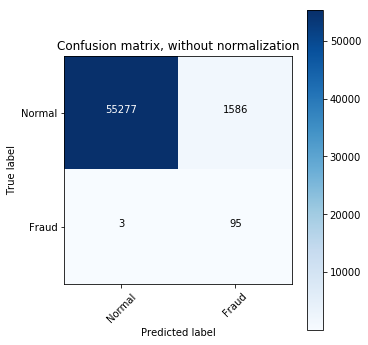

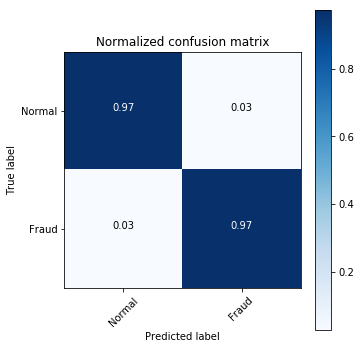

In [36]:
plotConfusion(clf, X_test_, y_test_)

**5.2.3/ Selecting probabitiy threshold for the Logistic Regression Model Classification: **

This classification scoring is going to be examined further in order to find the opitmal point where the model can achieve not only high score in dectecting Fraud (Recall Score), but also high score in correctly classifying Normal transactions (Precision Score) due to the following aspects:
*     High Fraud classification (Recall score) rate will obviously help business/bank from losing money
*     High Normal classification (Precision score) rate will help improve the Customer Experience/Satisfactory

Probability Threshold: 0.10
Recall metric: 1.00
Precision metric: 0.01
Probability Threshold: 0.20
Recall metric: 1.00
Precision metric: 0.05
Probability Threshold: 0.30
Recall metric: 0.99
Precision metric: 0.39
Probability Threshold: 0.40
Recall metric: 0.99
Precision metric: 0.84
Probability Threshold: 0.50
Recall metric: 0.97
Precision metric: 0.97
Probability Threshold: 0.60
Recall metric: 0.95
Precision metric: 0.99
Probability Threshold: 0.70
Recall metric: 0.93
Precision metric: 1.00
Probability Threshold: 0.80
Recall metric: 0.91
Precision metric: 1.00
Probability Threshold: 0.90
Recall metric: 0.83
Precision metric: 1.00


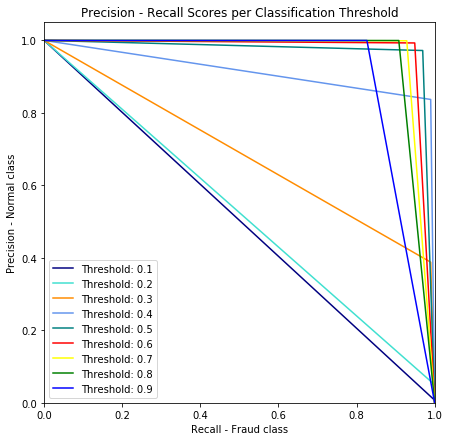

In [37]:
y_pred_test_proba = clf.predict_proba(X_test_)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

prec, rec = [],[]
for i in thresholds:
    y_test_predictions_high_recall = y_pred_test_proba[:,1] > i
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    
    p = float(cnf_matrix[0,0])/(cnf_matrix[0,1]+cnf_matrix[0,0])
    r = float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1])
    rec.append(r)
    prec.append(p)

    print("Probability Threshold: {0:0.2f}".format(i))
    print("Recall metric: {0:0.2f}".format(r))
    print("Precision metric: {0:0.2f}".format(p))

plt.figure(figsize=(7,7))

for i,color,r,p in zip(thresholds,colors,rec,prec):
    plt.plot([0, r, 1], [1, p, 0],color=color, label='Threshold: %s'%i)
    plt.ylabel('Precision - Normal class')
    plt.xlabel('Recall - Fraud class')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision - Recall Scores per Classification Threshold')
    plt.legend(loc="lower left")

We will select the Optimal Threshold where it helps achieve the goal for both Recall (Fraud detection rate) score and Precision score.

**6.1 / SVM model**

***6.1.1/ Fitting SVM Model:***

In [38]:
tuned_parameters = [{'kernel': ['rbf','poly'], 'gamma': [1e-3,  1e-4], 'C': [1,10,100,1000]}]
scores = ['precision', 'recall']

In [39]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    svm = GridSearchCV(SVC(), tuned_parameters, cv=5,scoring='%s_macro' % score)
    svm.fit(X_train_, y_train_)

    print("Best parameters set found on Training dataset:")
    print()
    print(svm.best_params_)
    print()
    print("Grid scores on Training dataset:")
    print()
    means = svm.cv_results_['mean_test_score']
    stds = svm.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, svm.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    y_true_test_svm, y_pred_test_svm = y_test_, svm.predict(X_test_)
    print(classification_report(y_true_test_svm, y_pred_test_svm))
    print()

# Tuning hyper-parameters for precision



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on Training dataset:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on Training dataset:

0.917 (+/-0.025) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.819 (+/-0.024) for {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.898 (+/-0.040) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.351 (+/-0.404) for {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.915 (+/-0.030) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.846 (+/-0.038) for {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}
0.916 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.756 (+/-0.080) for {'C': 10, 'gamma': 0.0001, 'kernel': 'poly'}
0.917 (+/-0.030) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.870 (+/-0.019) for {'C': 100, 'gamma': 0.001, 'kernel': 'poly'}
0.914 (+/-0.031) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.772 (+/-0.059) for {'C': 100, 'gamma': 0.0001, 'kernel': 'poly'}
0.918 (+/-0.043) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.893 (+/-0.032) for {'C':

Confusion matrix, without normalization
[[56393   470]
 [    4    94]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.04  0.96]]


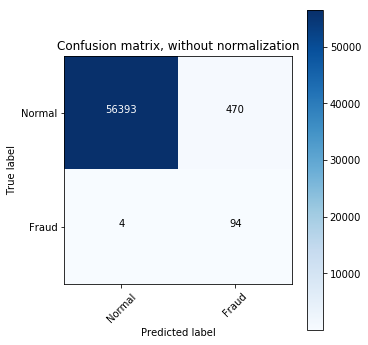

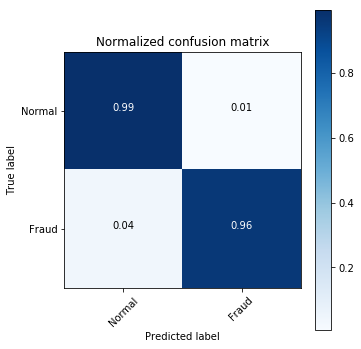

In [40]:
plotConfusion(svm, X_test_, y_test_)